In [ ]:
import sys, os
sys.path.append(os.path.abspath("/Users/DavidHolzwarth/Uni/EPFL/bachelors-thesis"))

import time
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
import pandas as pd

import LE as le
import LP as lp
import iterative as iterative
import logger_creator

import graph_tools
import networkx as nx

/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/dash_bootstrap_components/_table.py:5: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


In [ ]:
range_x = range(0, 2001, 200)

time_data_le = []
time_data_lp = []
time_data_iterative = []
x = []

logger, handler = logger_creator.create_logger("benchmarking")

for num_loops in range(1):
    times_le = []
    times_lp = []
    times_iterative = []

    for num_nodes in range_x:
        print(num_nodes)

        dense_graph = nx.gnp_random_graph(num_nodes, p=0.50, directed=True)
        delegation_graph = graph_tools.prepare_graph(dense_graph.nodes(), dense_graph.edges(), sink_frac = 0.1)
        delegations_orig = graph_tools.nx_graph_to_dict(delegation_graph)

        delegations = graph_tools.invert_graph(delegations_orig)
        nodes = list(delegation_graph)

        # Verify the solutions are equal
        powers_le, sinks_le = le.resolve_delegations(delegations, nodes)
        powers_lp, sinks_lp = lp.resolve_delegations(delegations, nodes)
        powers_iter = iterative.iterate_delegations(delegations, nodes)


        if powers_le.keys() != powers_lp.keys() or any(abs(powers_le[k] - powers_lp[k]) > 10**-6 for k in powers_le):
            logger.error("Powers do not match")
            logger.error(f"LE: {powers_le}")
            logger.error(f"LP: {powers_lp}")
            print("Mismatching powers in LE and LP. Check the log file for details.")
            break

        for node in sinks_le:
            if (abs(powers_lp[node] - powers_iter[node]) < 0.01):
                continue
            else: 
                logger.error("Powers do not match")
                logger.error(f"LP: {powers_lp}")
                logger.error(f"Iterative: {powers_iter}")
                print("Mismatching powers in LP and Iterative. Check the log file for details.")
                break

        n = 1
        if 0 <= num_nodes < 500:
            n = 5
        elif 500 <= num_nodes < 1000:
            n = 2

        # LE
        le_model = le.set_up(delegations, nodes)
        start_time = time.time()
        for _ in range(n):
            le.solve(*le_model)
        end_time = time.time()
        
        times_le.append((end_time - start_time) / n)

        # LP
        lp_model = lp.set_up(delegations, nodes)
        start_time = time.time()
        for _ in range(n):
            lp.solve(*lp_model)
        end_time = time.time()

        times_lp.append((end_time - start_time) / n)
    
        # Iterative
        start_time = time.time()
        for _ in range(n):
            p = iterative.iterate_delegations(delegations, nodes, cutoff=0.0001)
        end_time = time.time()

        times_iterative.append((end_time - start_time) / n)


    time_data_le.append(times_le)
    time_data_lp.append(times_lp)
    time_data_iterative.append(times_iterative)

logger.removeHandler(handler)
handler.close()

x  = list(range_x)

0
200
400
600
800
1000
1200
1400
1600
1800
2000


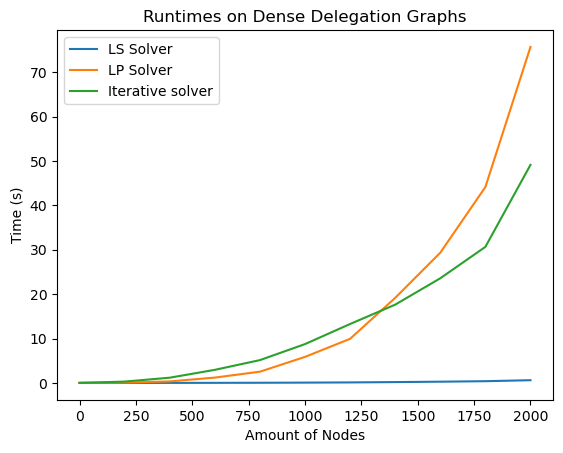

In [9]:
plt.clf()

plt.plot(x, times_le, label=f"LS Solver")
plt.plot(x, times_lp, label=f"LP Solver") 
plt.plot(x, times_iterative, label=f"Iterative solver")  

plt.legend()
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.title("Runtimes on Dense Delegation Graphs")
plt.show()

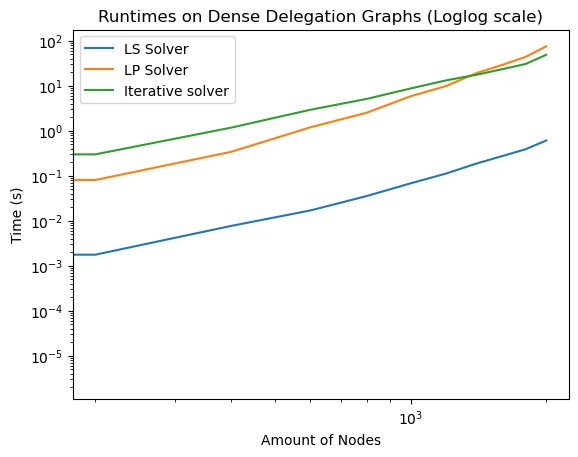

In [15]:
plt.clf()

plt.plot(x, times_le, label=f"LS Solver")
plt.plot(x, times_lp, label=f"LP Solver") 
plt.plot(x, times_iterative, label=f"Iterative solver")  

plt.legend()
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.title("Runtimes on Dense Delegation Graphs (Loglog scale)")
plt.loglog()
plt.show()

In [23]:
print("x = ", x)
print("times_iterative = ", times_iterative)
print("times_le = ", times_le)
print("times_lp = ", times_lp)

x =  [0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
times_iterative =  [0.0002475738525390625, 0.30032639503479003, 1.1781693935394286, 2.9478615522384644, 5.138198494911194, 8.745582818984985, 13.275913953781128, 17.634682178497314, 23.57251811027527, 30.650930881500244, 49.12122821807861]
times_le =  [2.574920654296875e-06, 0.0017689704895019532, 0.0077060222625732425, 0.017034173011779785, 0.035616517066955566, 0.06811165809631348, 0.1127328872680664, 0.18755221366882324, 0.2766540050506592, 0.3901040554046631, 0.6113779544830322]
times_lp =  [0.0322606086730957, 0.08082699775695801, 0.34155898094177245, 1.2009680271148682, 2.5320690870285034, 5.865067005157471, 9.939854145050049, 19.16150689125061, 29.337282180786133, 44.133265256881714, 75.6855959892273]


In [ ]:
y = times_le[1:]

results = {}

# 1. Power law: log-log
log_x = np.log(x[1:])
log_y = np.log(y)
slope, intercept, r_value, _, _ = linregress(log_x, log_y)
results['Power law'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 2. Exponential: log-y
slope, intercept, r_value, _, _ = linregress(x[1:], np.log(y))
results['Exponential'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 3. Linear: raw scale
slope, intercept, r_value, _, _ = linregress(x[1:], y)
results['Linear'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 4. Log-linear: log(x) vs. y
slope, intercept, r_value, _, _ = linregress(np.log(x[1:]), y)
results['Log-linear'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

df_results_le = pd.DataFrame(results).T

print("Results for LS:")
display(df_results_le)

y = times_lp[1:]

# Store model fits and R² values
results = {}

# 1. Power law: log-log
log_x = np.log(x[1:])
log_y = np.log(y)
slope, intercept, r_value, _, _ = linregress(log_x, log_y)
results['Power law'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 2. Exponential: log-y
slope, intercept, r_value, _, _ = linregress(x[1:], np.log(y))
results['Exponential'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 3. Linear: raw scale
slope, intercept, r_value, _, _ = linregress(x[1:], y)
results['Linear'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 4. Log-linear: log(x) vs. y
slope, intercept, r_value, _, _ = linregress(np.log(x[1:]), y)
results['Log-linear'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

df_results_lp = pd.DataFrame(results).T

print("Results for LP:")
display(df_results_lp)


y = times_iterative[1:]

# Store model fits and R² values
results = {}

# 1. Power law: log-log
log_x = np.log(x[1:])
log_y = np.log(y)
slope, intercept, r_value, _, _ = linregress(log_x, log_y)
results['Power law'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 2. Exponential: log-y
slope, intercept, r_value, _, _ = linregress(x[1:], np.log(y))
results['Exponential'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 3. Linear: raw scale
slope, intercept, r_value, _, _ = linregress(x[1:], y)
results['Linear'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 4. Log-linear: log(x) vs. y
slope, intercept, r_value, _, _ = linregress(np.log(x[1:]), y)
results['Log-linear'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

df_results_iterative = pd.DataFrame(results).T

print("Results for Iterative:")
display(df_results_iterative)

,R2,slope,intercept
Power law,0.989758,2.536002,-20.054228
Exponential,0.954814,0.003015,-6.104003
Linear,0.824577,0.000302,-0.161194
Log-linear,0.577669,0.208721,-1.250263


,R2,slope,intercept
Power law,0.988070,3.007615,-18.874766
Exponential,0.956058,0.003581,-2.336179
Linear,0.769253,0.035807,-20.559852
Log-linear,0.518775,24.290690,-146.561646


,R2,slope,intercept
Power law,0.997216,2.162965,-12.749081
Exponential,0.924522,0.002521,-0.795221
Linear,0.869095,0.023965,-11.104809
Log-linear,0.643620,17.036245,-100.739140


# Testing this to the extreme

In [ ]:
range_x = range(0, 5001, 1000)

time_data_le = []
time_data_lp = []
time_data_iterative = []
x = []

logger, handler = logger_creator.create_logger("benchmarking")

for num_loops in range(1):
    times_le = []
    times_lp = []
    times_iterative = []

    for num_nodes in range_x:
        print(num_nodes)

        dense_graph = nx.gnp_random_graph(num_nodes, p=0.50, directed=True)
        delegation_graph = graph_tools.prepare_graph(dense_graph.nodes(), dense_graph.edges(), sink_frac = 0.1)
        delegations_orig = graph_tools.nx_graph_to_dict(delegation_graph)

        final_num_nodes = len(delegation_graph) # Save the number of nodes for the graphs
        x.append(final_num_nodes)

        delegations = graph_tools.invert_graph(delegations_orig)
        nodes = list(delegation_graph)

        # # Verify the solutions are equal
        # powers_le, sinks_le = le.resolve_delegations(delegations, nodes)
        # powers_lp, sinks_lp = lp.resolve_delegations(delegations, nodes)
        # powers_iter = iterative.iterate_delegations(delegations, nodes)


        # if powers_le.keys() != powers_lp.keys() or any(abs(powers_le[k] - powers_lp[k]) > 10**-6 for k in powers_le):
        #     logger.error("Powers do not match")
        #     logger.error(f"LE: {powers_le}")
        #     logger.error(f"LP: {powers_lp}")
        #     print("Mismatching powers in LE and LP. Check the log file for details.")
        #     break

        # for node in sinks_le:
        #     if (abs(powers_lp[node] - powers_iter[node]) < 0.01):
        #         continue
        #     else: 
        #         logger.error("Powers do not match")
        #         logger.error(f"LP: {powers_lp}")
        #         logger.error(f"Iterative: {powers_iter}")
        #         print("Mismatching powers in LP and Iterative. Check the log file for details.")
        #         break

        n = 1
        if 0 <= num_nodes < 500:
            n = 5
        elif 500 <= num_nodes < 1000:
            n = 2

        # LE
        le_model = le.set_up(delegations, nodes)
        start_time = time.time()
        for _ in range(n):
            le.solve(*le_model)
        end_time = time.time()
        
        times_le.append((end_time - start_time) / n)

        # LP
        lp_model = lp.set_up(delegations, nodes)
        start_time = time.time()
        for _ in range(n):
            lp.solve(*lp_model)
        end_time = time.time()

        times_lp.append((end_time - start_time) / n)
    
        # Iterative
        start_time = time.time()
        for _ in range(n):
            p = iterative.iterate_delegations(delegations, nodes, cutoff=0.0001)
        end_time = time.time()

        times_iterative.append((end_time - start_time) / n)


    time_data_le.append(times_le)
    time_data_lp.append(times_lp)
    time_data_iterative.append(times_iterative)

logger.removeHandler(handler)
handler.close()

0
1000
2000
3000
4000
5000


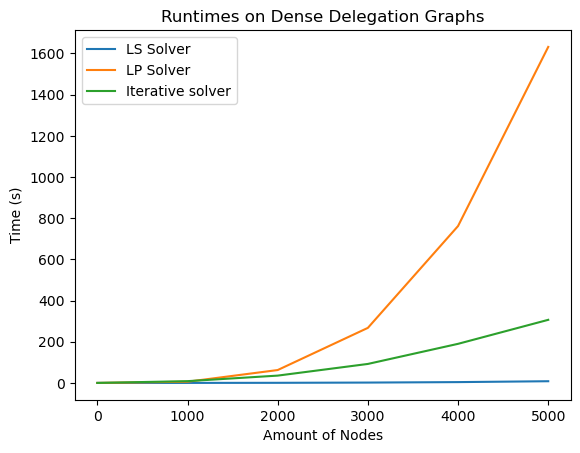

In [25]:
plt.clf()

plt.plot(x, times_le, label=f"LS Solver")
plt.plot(x, times_lp, label=f"LP Solver") 
plt.plot(x, times_iterative, label=f"Iterative solver")  

plt.legend()
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.title("Runtimes on Dense Delegation Graphs")
plt.show()

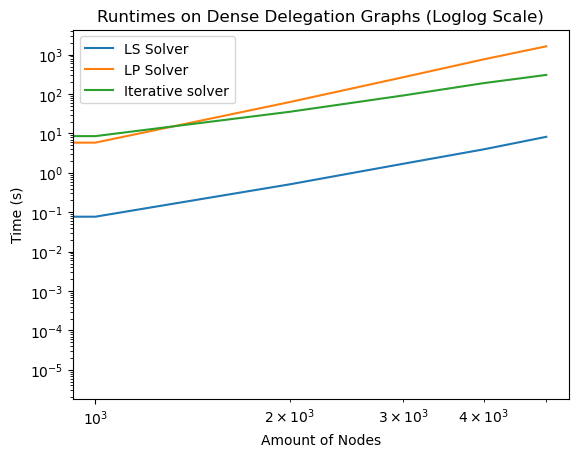

In [29]:
plt.clf()

plt.plot(x, times_le, label=f"LS Solver")
plt.plot(x, times_lp, label=f"LP Solver") 
plt.plot(x, times_iterative, label=f"Iterative solver")  

plt.legend()
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.title("Runtimes on Dense Delegation Graphs (Loglog Scale)")
plt.loglog()
plt.show()

In [27]:
print("x = ", x)
print("times_iterative = ", times_iterative)
print("times_le = ", times_le)
print("times_lp = ", times_lp)

x =  [0, 1000, 2000, 3000, 4000, 5000]
times_iterative =  [0.00022296905517578126, 8.565044164657593, 35.49983286857605, 92.18052697181702, 189.81616020202637, 306.3841428756714]
times_le =  [4.816055297851562e-06, 0.07717490196228027, 0.5107781887054443, 1.701857089996338, 3.954846143722534, 8.226731061935425]
times_lp =  [0.04515275955200195, 5.85373592376709, 62.53675699234009, 267.3006477355957, 761.7910118103027, 1631.5741529464722]


In [ ]:
y = times_le[1:]

results = {}

# 1. Power law: log-log
log_x = np.log(x[1:])
log_y = np.log(y)
slope, intercept, r_value, _, _ = linregress(log_x, log_y)
results['Power law'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 2. Exponential: log-y
slope, intercept, r_value, _, _ = linregress(x[1:], np.log(y))
results['Exponential'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 3. Linear: raw scale
slope, intercept, r_value, _, _ = linregress(x[1:], y)
results['Linear'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 4. Log-linear: log(x) vs. y
slope, intercept, r_value, _, _ = linregress(np.log(x[1:]), y)
results['Log-linear'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

df_results_le = pd.DataFrame(results).T

display(df_results_le)


y = times_lp[1:]

# Store model fits and R² values
results = {}

# 1. Power law: log-log
log_x = np.log(x[1:])
log_y = np.log(y)
slope, intercept, r_value, _, _ = linregress(log_x, log_y)
results['Power law'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 2. Exponential: log-y
slope, intercept, r_value, _, _ = linregress(x[1:], np.log(y))
results['Exponential'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 3. Linear: raw scale
slope, intercept, r_value, _, _ = linregress(x[1:], y)
results['Linear'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 4. Log-linear: log(x) vs. y
slope, intercept, r_value, _, _ = linregress(np.log(x[1:]), y)
results['Log-linear'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

df_results_lp = pd.DataFrame(results).T

display(df_results_lp)

y = times_iterative[1:]

# Store model fits and R² values
results = {}

# 1. Power law: log-log
log_x = np.log(x[1:])
log_y = np.log(y)
slope, intercept, r_value, _, _ = linregress(log_x, log_y)
results['Power law'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 2. Exponential: log-y
slope, intercept, r_value, _, _ = linregress(x[1:], np.log(y))
results['Exponential'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 3. Linear: raw scale
slope, intercept, r_value, _, _ = linregress(x[1:], y)
results['Linear'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 4. Log-linear: log(x) vs. y
slope, intercept, r_value, _, _ = linregress(np.log(x[1:]), y)
results['Log-linear'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

df_results_iterative = pd.DataFrame(results).T

display(df_results_iterative)

,R2,slope,intercept
Power law,0.999075,2.890081,-22.575112
Exponential,0.959693,0.001138,-3.259360
Linear,0.873998,0.001974,-3.028677
Log-linear,0.697770,4.389005,-31.626363


,R2,slope,intercept
Power law,0.999847,3.510561,-22.506615
Exponential,0.950903,0.001376,0.976729
Linear,0.853733,0.395070,-639.397266
Log-linear,0.669260,870.277632,-6299.143042


,R2,slope,intercept
Power law,0.998451,2.240859,-13.382555
Exponential,0.959835,0.000883,1.593124
Linear,0.941549,0.074995,-98.497216
Log-linear,0.792582,171.192053,-1219.979776


In [ ]:
# Playing around 
range_x = range(0, 5001, 1000)

num_nodes = 10000

dense_graph = nx.gnp_random_graph(num_nodes, p=0.50, directed=True)
delegation_graph = graph_tools.prepare_graph(dense_graph.nodes(), dense_graph.edges(), sink_frac = 0.1)
delegations_orig = graph_tools.nx_graph_to_dict(delegation_graph)

final_num_nodes = len(delegation_graph) # Save the number of nodes for the graphs
x.append(final_num_nodes)

delegations = graph_tools.invert_graph(delegations_orig)
nodes = list(delegation_graph)

n = 1
if 0 <= num_nodes < 500:
    n = 5
elif 500 <= num_nodes < 1000:
    n = 2

# LE
le_model = le.set_up(delegations, nodes)
start_time = time.time()
for _ in range(n):
    le.solve(*le_model)
end_time = time.time()

times_le.append((end_time - start_time) / n)

print(times_le)


logger.removeHandler(handler)
handler.close()



Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x10414ac30>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


NameError: name 'x' is not defined